# <center> Recommender System </center>

## Preparation

Connect to drive (if needed)

In [1]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

DRIVE_DIR = ""
USING_DRIVE = False
if USING_DRIVE:
    # from google.colab import drive
    # drive.mount('/content/drive')
    DRIVE_DIR = "drive/My Drive/Bangkit/"

# Check GPU
devices = tf.config.experimental.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Constants

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "classical"
REMARK = "Try current best with 256 batch and categorized follower"
BATCH_SIZE = 256
LEARNING_RATE = 1e-5
EPOCH = 100
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanSquaredError()

Log dir

In [3]:
DETAIL_DIR = os.path.join(DRIVE_DIR, "log/detail/")
MODEL_DIR = os.path.join(DRIVE_DIR, "log/model/savedmodel/")
KERAS_DIR = os.path.join(DRIVE_DIR, "log/model/keras/")
PLOT_DIR = os.path.join(DRIVE_DIR, "log/plot")
SUMMARY_DIR = os.path.join(DRIVE_DIR, "log/model/summary/")

if (os.path.exists(os.path.join(MODEL_DIR, LOG_NAME)) or 
    os.path.exists(os.path.join(KERAS_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(PLOT_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(SUMMARY_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME))):
    raise FileExistsError


## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [4]:
DATA_DIR = os.path.join(DRIVE_DIR, "data/synt_data_categorize_follower/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [5]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,price_category
0,1723,HIGH,HIGH,HIGH,"Drama,Romance,School,Supernatural",HIGH
1,82,HIGH,HIGH,HIGH,"Action,Adventure,Drama,Fantasy,Shounen",HIGH
2,296,HIGH,HIGH,HIGH,"Action,Comedy,Sci-Fi,Shounen",HIGH
3,127,HIGH,HIGH,HIGH,Sci-Fi,HIGH
4,137,HIGH,HIGH,HIGH,"Action,Comedy,Sci-Fi,Shounen",HIGH


In [6]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6238 entries, 0 to 6237
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              6238 non-null   int64 
 1   insta_follower  6238 non-null   object
 2   tiktok          6238 non-null   object
 3   youtube         6238 non-null   object
 4   categories      6238 non-null   object
 5   price_category  6238 non-null   object
dtypes: int64(1), object(5)
memory usage: 292.5+ KB


In [7]:
df_influencer.describe()

,id
count,6238.000000
mean,3476.966656
std,2136.753019
min,1.000000
25%,1610.250000
50%,3308.500000
75%,5285.750000
max,7387.000000


In [8]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.82
1,1,3,3,0.56
2,1,5,5,0.93
3,1,6,5,1.00
4,1,7,4,0.74


In [9]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409712 entries, 0 to 409711
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            409712 non-null  int64  
 1   inf_id            409712 non-null  int64  
 2   star_rating       409712 non-null  int64  
 3   sentiment_rating  409712 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.5 MB


In [10]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,409712.000000,409712.000000,409712.000000,409712.000000
mean,2446.166034,1079.041366,4.141360,0.777423
std,1438.816431,1149.462867,0.789167,0.161781
min,1.000000,1.000000,1.000000,0.000000
25%,1215.000000,261.000000,4.000000,0.680000
50%,2460.000000,640.000000,4.000000,0.790000
75%,3699.000000,1538.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [11]:
df_influencer.isnull().sum()

id                0
insta_follower    0
tiktok            0
youtube           0
categories        0
price_category    0
dtype: int64

In [12]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [13]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [14]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [15]:
# follower_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

df_inf_norm = one_hot(df_inf_norm, 'youtube') 
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1723,1,0,0,0,0,0,1,0,1,...,1,1,0,0,1,0,0,1,0,0
1,82,1,0,0,1,1,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0
2,296,1,0,0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,127,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,137,1,0,0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0


Combine star and sentiment rating

In [16]:
STAR_WEIGHT = 0.6
SENTIMENT_WEIGHT = 0.4

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,1,1,4,0.82,0.808
1,1,3,3,0.56,0.584
2,1,5,5,0.93,0.972
3,1,6,5,1.00,1.000
4,1,7,4,0.74,0.776
...,...,...,...,...,...
409707,4999,49,5,0.90,0.960
409708,4999,670,5,0.82,0.928
409709,4999,62,5,0.80,0.920
409710,4999,770,5,0.98,0.992


In [17]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2711,2711,2711,2711
2,9155,9155,9155,9155
3,58985,58985,58985,58985
4,195516,195516,195516,195516
5,143345,143345,143345,143345


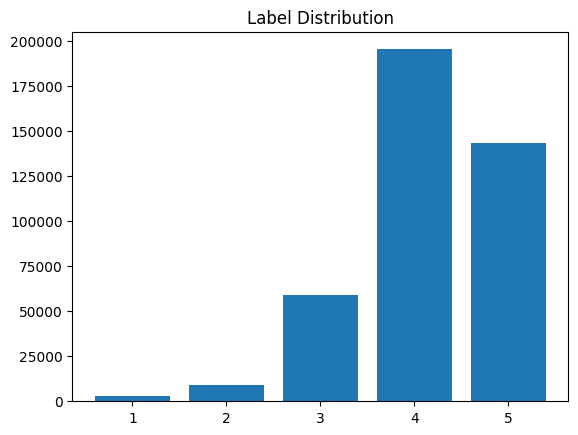

In [18]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [19]:
df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features.head()

,own_id,inf_id,combined_rating,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,1,0.808,1,0,0,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
1,1,3,0.584,3,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1,5,0.972,5,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,6,1.000,6,1,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
4,1,7,0.776,7,1,0,0,0,0,1,...,1,1,0,0,1,0,0,1,0,0


In [20]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm.head()

,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Action,Adventure,Comedy,Drama,Fantasy,Romance,...,Supernatural,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,0.545000,0.000000,0.295500,0.309000,0.000000,0.374500,0.541500,0.216000,0.434500,...,0.440500,0.840500,0.0,0.000000,0.840500,0.0,0.000000,0.840500,0.0,0.000000
1,2,0.462334,0.032486,0.382869,0.376729,0.185119,0.417301,0.200170,0.251623,0.252754,...,0.246675,0.782018,0.0,0.095672,0.809617,0.0,0.068073,0.580511,0.0,0.297179
2,3,0.585529,0.000000,0.297176,0.262353,0.220471,0.530471,0.246471,0.239765,0.254706,...,0.190706,0.831176,0.0,0.051529,0.882706,0.0,0.000000,0.610000,0.0,0.272706
3,4,0.709951,0.000000,0.114829,0.626634,0.264683,0.389951,0.135805,0.326927,0.306244,...,0.383220,0.805659,0.0,0.019122,0.805659,0.0,0.019122,0.805659,0.0,0.019122
4,5,0.617409,0.000000,0.198000,0.285409,0.141818,0.434591,0.219909,0.177000,0.224273,...,0.272682,0.806682,0.0,0.008727,0.806682,0.0,0.008727,0.736500,0.0,0.078909


## Creating Model

Trying to use classical cosine similarity

In [39]:
def calculate_cosine_similarity(user_profile, influencer_data):
    # Calculate cosine similarity using numpy
    ids = influencer_data[:, 0]
    influencer_data = influencer_data[:, 1:] 
    # influencer_data = influencer_data / np.linalg.norm(user_profile) 
    # user_profile = user_profile / np.linalg.norm(user_profile)
    similarity_scores = np.dot(user_profile, influencer_data.T) / (np.linalg.norm(user_profile) * np.linalg.norm(influencer_data, axis=1))

    return ids, similarity_scores

def assign_ratings(similarity_scores, rating_scale):
    # Rank influencers based on similarity scores
    ranked_indices = np.argsort(similarity_scores)[::-1]

    # Assign ratings based on rank
    num_influencers = len(similarity_scores)
    ratings = np.zeros(num_influencers)
    for i, idx in enumerate(ranked_indices):
        rating = rating_scale[i // (num_influencers // len(rating_scale))]
        ratings[idx] = rating

    return ratings


In [48]:
similarity_scores = np.array([[0, 0, 0]])
for owner in df_own_norm.to_numpy()[:10]:
    id = int(owner[0])
    owner = owner[1:]
    
    inf_ids, scores = calculate_cosine_similarity(owner, df_inf_norm.to_numpy()[:10])
    own_ids = np.full(len(inf_ids), id)

    
# similarity_scores = [item for sublist in similarity_scores for item in sublist]
similarity_scores

ValueError: all input arrays must have the same shape

In [26]:
prediction = pd.DataFrame(similarity_scores, columns=['own_id', 'inf_id', 'predicted_score'])

ValueError: Empty data passed with indices specified.

In [ ]:
compare = df_history.copy()

compare.merge(prediction, on=['own_id', 'inf_id'])
compare

ValueError: 3 columns passed, passed data had 6238 columns

In [ ]:
Stopper

# Deep Learning

In [ ]:
def plot_history(history, save=False):
    # Extract the loss, MAE, and MSE values from the history object
    loss = history.history['loss']
    mse = history.history['mse']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    # Create a figure and set up the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

    # Plot the loss history
    plt.title(REMARK)
    ax1.plot(loss, label='Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the MSE history
    ax2.plot(mse, label='MSE')
    ax2.plot(val_mse, label='Val MSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Plot the MAE history
    ax3.plot(mae, label='MAE')
    ax3.plot(val_mae, label='Val MAE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAE')
    ax3.legend()

    # Show the plot
    plt.tight_layout()
    if (save):
        if (not os.path.exists(os.path.join(PLOT_DIR, LOG_NAME))):
            plt.savefig(os.path.join(PLOT_DIR, LOG_NAME))
    
    plt.show()

In [ ]:
plot_history(history)
plot_history(history, save=True)


### Evaluation with test dataset

In [ ]:
test_predict = model.predict(test_dataset)
test_predict

In [ ]:
# Get real label
test_labels = np.array([])
for batch in test_dataset:
    test_labels = np.concatenate([test_labels, batch[1].numpy()])

test_labels

In [ ]:
compare_test = pd.concat([pd.DataFrame(test_predict, columns=["predicted"]), 
                     pd.DataFrame(test_labels, columns=["real"])], axis=1)

compare_test["error"] = abs(compare_test["predicted"] - compare_test["real"])

compare_test

In [ ]:
compare_test[compare_test["error"] >= 1e-1]

In [ ]:
train_predict = model.predict(train_dataset)
train_predict

In [ ]:
# Get real label
train_labels = np.array([])
for batch in train_dataset:
    train_labels = np.concatenate([train_labels, batch[1].numpy()])

train_labels

In [ ]:
compare_train = pd.concat([pd.DataFrame(train_predict, columns=["predicted"]), 
                     pd.DataFrame(train_labels, columns=["real"])], axis=1)

compare_train["error"] = abs(compare_train["predicted"] - compare_train["real"])

compare_train

In [ ]:
compare_train[compare_train["error"] >= 4e-1]

## Logging

In [ ]:
if (not os.path.exists(os.path.join(MODEL_DIR, LOG_NAME))):
    tf.saved_model.save(model, os.path.join(MODEL_DIR, LOG_NAME))

In [ ]:
if (not os.path.exists(os.path.join(KERAS_DIR, LOG_NAME))):
    model.save(os.path.join(KERAS_DIR, LOG_NAME))

In [ ]:
def serialize(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError("Object of type {} is not JSON serializable".format(type(obj)))

In [ ]:
import json
from datetime import timedelta

log = {
    "name": LOG_NAME,
    "training_time": str(timedelta(training_time)),
    "remark": REMARK,
    "test_error": compare_test["error"].mean(),
    "results": {
        "last_loss": history.history["loss"][-1],
        "last_mae": history.history["mae"][-1],
        "last_mse": history.history["mse"][-1],
        "last_val_loss": history.history["val_loss"][-1],
        "last_val_mae": history.history["val_mae"][-1],
        "last_val_mse": history.history["val_mse"][-1],
    },
    "hyperparameter": {
        "learning_rate": LEARNING_RATE,
        "epoch": EPOCH,
        "batch_size": BATCH_SIZE,
        "loss_func": tf.keras.losses.serialize(LOSS_FN)["class_name"],
        "optimizer": tf.keras.optimizers.serialize(OPTIMIZER)["class_name"],
    },
    "data_distribution": {
        "positive": POSITIVE_SIZE,
        "negative": NEGATIVE_SIZE,
        "training_pos": TRAIN_POS_SIZE,
        "training_neg": TRAIN_NEG_SIZE,
    },
    "data_example": {
        "influencer": df_influencer.head().to_dict(),
        "owner": df_own_norm.head().to_dict(),
        "history": df_history.head().to_dict(),
    },
    "eval": {
        "loss": history.history["loss"],
        "mae": history.history["mae"],
        "mse": history.history["mse"],
        "val_loss": history.history["val_loss"],
        "val_mae": history.history["val_mae"],
        "val_mse": history.history["val_mse"],
    }
}
if (not os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME + ".json"))):
    with open(os.path.join(DETAIL_DIR, LOG_NAME + '.json'), 'w') as json_file:
        log = json.dumps(log, default=serialize)
        json_file.write(log)

In [ ]:
summary = model.summary()

In [ ]:
from contextlib import redirect_stdout

with open(os.path.join(SUMMARY_DIR, LOG_NAME + ".txt"), 'w') as f:
    with redirect_stdout(f):
        print("Influencer Model:")
        model_influencer.summary()
        
        print("\nOwner Model:")
        model_owner.summary()
        
        print("\nFull Model:")
        model.summary()